## Project Intro: Intel Lab Data

This notebook contains information about data collected from 54 sensors deployed in the Intel Berkeley Research lab between February 28th and April 5th, 2004.

`Mica2Dot` sensors with weather boards collected timestamped topology information, along with humidity, temperature, light and voltage values once every 31 seconds.

Source: http://db.csail.mit.edu/labdata/labdata.html

## Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import SeasonalAD
from adtk.data import to_events

## Dataset

### Dataset #1: Sensor Data

In [3]:
sensor_data = pd.read_csv('data/data.txt', sep=" ", header=None)
sensor_data.head()

,0,1,2,3,4,5,6,7
0,2004-03-31,03:38:15.757551,2,1.0,122.1530,-3.91901,11.04,2.03397
1,2004-02-28,00:59:16.02785,3,1.0,19.9884,37.09330,45.08,2.69964
2,2004-02-28,01:03:16.33393,11,1.0,19.3024,38.46290,45.08,2.68742
3,2004-02-28,01:06:16.013453,17,1.0,19.1652,38.80390,45.08,2.68742
4,2004-02-28,01:06:46.778088,18,1.0,19.1750,38.83790,45.08,2.69964


In [4]:
sensor_data.columns = ['date', 'time', 'epoch', 'mote_id', 
                       'temperature', 'humidity', 'light', 'voltage']
sensor_data.head()

,date,time,epoch,mote_id,temperature,humidity,light,voltage
0,2004-03-31,03:38:15.757551,2,1.0,122.1530,-3.91901,11.04,2.03397
1,2004-02-28,00:59:16.02785,3,1.0,19.9884,37.09330,45.08,2.69964
2,2004-02-28,01:03:16.33393,11,1.0,19.3024,38.46290,45.08,2.68742
3,2004-02-28,01:06:16.013453,17,1.0,19.1652,38.80390,45.08,2.68742
4,2004-02-28,01:06:46.778088,18,1.0,19.1750,38.83790,45.08,2.69964


### Inspect sensor data

In [5]:
sensor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2313682 entries, 0 to 2313681
Data columns (total 8 columns):
date           object
time           object
epoch          int64
mote_id        float64
temperature    float64
humidity       float64
light          float64
voltage        float64
dtypes: float64(5), int64(1), object(2)
memory usage: 141.2+ MB


In [6]:
sensor_data[['temperature', 'humidity', 'light', 'voltage']].describe()

,temperature,humidity,light,voltage
count,2.312781e+06,2.312780e+06,2.219804e+06,2.313156e+06
mean,3.920700e+01,3.390814e+01,4.072110e+02,2.492552e+00
std,3.741923e+01,1.732152e+01,5.394276e+02,1.795743e-01
min,-3.840000e+01,-8.983130e+03,0.000000e+00,9.100830e-03
25%,2.040980e+01,3.187760e+01,3.956000e+01,2.385220e+00
50%,2.243840e+01,3.928030e+01,1.582400e+02,2.527320e+00
75%,2.702480e+01,4.358550e+01,5.372800e+02,2.627960e+00
max,3.855680e+02,1.375120e+02,1.847360e+03,1.856000e+01


In [7]:
sensor_data[sensor_data.duplicated() == True].sum()

date           0.0
time           0.0
epoch          0.0
mote_id        0.0
temperature    0.0
humidity       0.0
light          0.0
voltage        0.0
dtype: float64

In [8]:
sensor_data.isna().sum()

date               0
time               0
epoch              0
mote_id          526
temperature      901
humidity         902
light          93878
voltage          526
dtype: int64

In [9]:
sensor_data.dropna(inplace=True)
sensor_data.isna().sum()

date           0
time           0
epoch          0
mote_id        0
temperature    0
humidity       0
light          0
voltage        0
dtype: int64

### Plot and inspect signals data

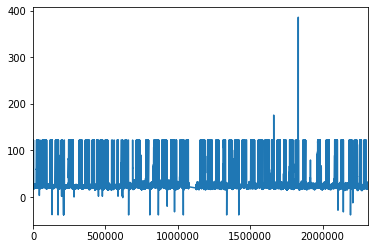

In [10]:
sensor_data['temperature'].plot()

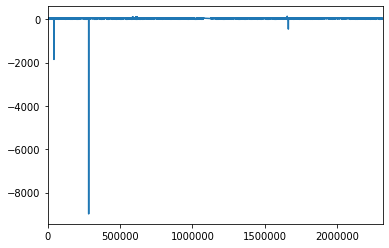

In [21]:
sensor_data['humidity'].plot()

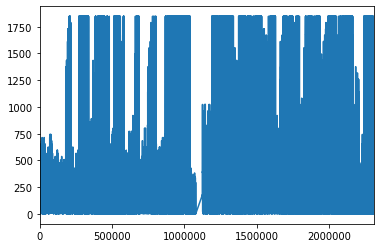

In [22]:
sensor_data['light'].plot()

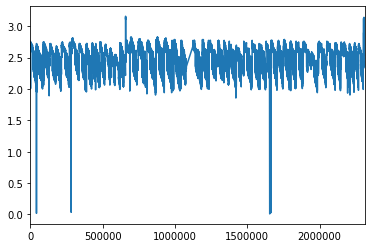

In [23]:
sensor_data['voltage'].plot()

### Remove anomaly with ADTK library

Quick tutorial: https://arundo-adtk.readthedocs-hosted.com/en/stable/quickstart.html

Steps:
1. Load and validate time series for training.
2. Visualize training time series.
3. Detect violation of seasonal pattern.
4. If known anomalies are available, cross check with detection results.
5. Apply the trained model to new data.

In [96]:
s_train_df = pd.DataFrame(sensor_data['date'] + ' ' + sensor_data['time'], columns=['datetime'])
s_train_df['datetime'] = pd.to_datetime(s_train_df['datetime'])
s_train_df['datetime'] = s_train_df['datetime'].values.astype('<M8[s]')
s_train_df['voltage'] = sensor_data['voltage']
s_train_df.set_index('datetime', inplace=True)
s_train_df.head(10)

,voltage
datetime,
2004-03-31 03:38:15,2.03397
2004-02-28 00:59:16,2.69964
2004-02-28 01:03:16,2.68742
2004-02-28 01:06:16,2.68742
2004-02-28 01:06:46,2.69964
2004-02-28 01:08:45,2.68742
2004-02-28 01:09:22,2.68742
2004-02-28 01:09:46,2.68742
2004-02-28 01:10:16,2.69964


In [89]:
s_train_df.describe()

,voltage
count,2.219803e+06
mean,2.490634e+00
std,1.784080e-01
min,9.100830e-03
25%,2.385220e+00
50%,2.527320e+00
75%,2.627960e+00
max,3.159150e+00


In [98]:
s_train = validate_series(s_train_df)
print(s_train)

                     voltage
datetime                    
2004-02-28 00:58:46  2.69964
2004-02-28 00:58:47  3.15915
2004-02-28 00:59:16  2.69964
2004-02-28 00:59:17  2.68742
2004-02-28 00:59:46  2.66332
...                      ...
2004-04-05 11:00:33  2.81479
2004-04-05 11:01:02  2.81479
2004-04-05 11:01:33  2.82819
2004-04-05 11:02:03  2.81479
2004-04-05 11:02:32  2.80151

[953363 rows x 1 columns]


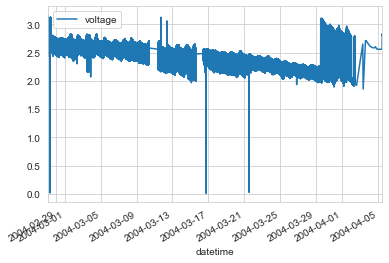

In [99]:
s_train.plot()

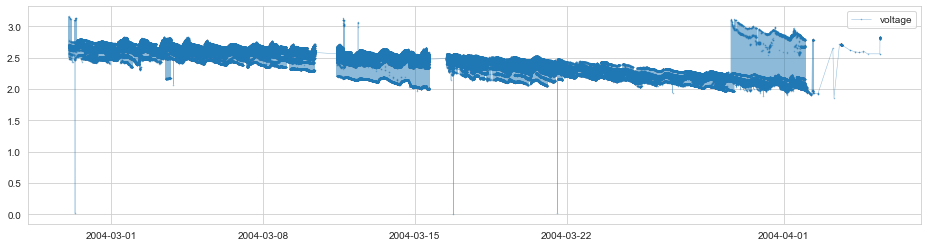

In [100]:
plot(s_train)

In [101]:
seasonal_ad = SeasonalAD()
anomalies = seasonal_ad.fit_detect(s_train)
plot(s_train, anomaly_pred=anomalies, ap_color='red', ap_marker_on_curve=True)

RuntimeError: Series does not follow any known frequency (e.g. second, minute, hour, day, week, month, year, etc.

### Dataset #2: Sensor Location

In [11]:
sensor_locs = pd.read_csv('data/mote_locs.txt', sep=" ", header=None)
sensor_locs.head()

,0,1,2
0,1,21.5,23
1,2,24.5,20
2,3,19.5,19
3,4,22.5,15
4,5,24.5,12


In [12]:
sensor_locs.columns = ['mote_id', 'x_coord', 'y_coord']
sensor_locs.head()

,mote_id,x_coord,y_coord
0,1,21.5,23
1,2,24.5,20
2,3,19.5,19
3,4,22.5,15
4,5,24.5,12


In [13]:
sensor_locs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 3 columns):
mote_id    54 non-null int64
x_coord    54 non-null float64
y_coord    54 non-null int64
dtypes: float64(1), int64(2)
memory usage: 1.4 KB


In [14]:
sensor_locs['mote_id'] = sensor_locs['mote_id'].astype(float)
sensor_locs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 3 columns):
mote_id    54 non-null float64
x_coord    54 non-null float64
y_coord    54 non-null int64
dtypes: float64(2), int64(1)
memory usage: 1.4 KB


### Inspect sensor location data

In [15]:
sensor_locs['mote_id'].nunique()

54

In [16]:
sensor_locs.isna().sum()

mote_id    0
x_coord    0
y_coord    0
dtype: int64

In [17]:
sensor_locs.duplicated().sum()

0

### Combine dataset #1 and #2

In [18]:
sensor_signals = sensor_data.merge(sensor_locs, how='left', left_on='mote_id', right_on='mote_id')
sensor_signals.head()

,date,time,epoch,mote_id,temperature,humidity,light,voltage,x_coord,y_coord
0,2004-03-31,03:38:15.757551,2,1.0,122.1530,-3.91901,11.04,2.03397,21.5,23.0
1,2004-02-28,00:59:16.02785,3,1.0,19.9884,37.09330,45.08,2.69964,21.5,23.0
2,2004-02-28,01:03:16.33393,11,1.0,19.3024,38.46290,45.08,2.68742,21.5,23.0
3,2004-02-28,01:06:16.013453,17,1.0,19.1652,38.80390,45.08,2.68742,21.5,23.0
4,2004-02-28,01:06:46.778088,18,1.0,19.1750,38.83790,45.08,2.69964,21.5,23.0


### Aggregate dataset by `mote_id`

In [20]:
agg_sensor_signals = sensor_signals.groupby('mote_id').mean()
agg_sensor_signals.drop('epoch', axis=1, inplace=True)
agg_sensor_signals.head()

,temperature,humidity,light,voltage,x_coord,y_coord
mote_id,,,,,,
1.0,35.882437,34.319280,156.575828,2.519643,21.5,23.0
2.0,40.201817,34.298739,212.159717,2.458436,24.5,20.0
3.0,33.716012,34.787920,146.052806,2.517967,19.5,19.0
4.0,45.464410,29.991159,155.491512,2.468170,22.5,15.0
6.0,27.561589,28.513638,453.114123,2.428337,19.5,12.0
